# Natural Language Processing with Deep Learning 

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [10]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
42827,68450204,Systems Support Administrator Top 100 Business,Our client is a leading organisation that due ...,Belfast,Belfast,full_time,contract,Abacus Professional Recruitment,Admin Jobs,"10,000 - 20,000",15000,nijobfinder.co.uk,9.615872
104166,69570346,New Business Sales Representative Event Manag...,An opportunity to work with a wellestablished ...,Hertfordshire - Letchworth Garden City,Letchworth Garden City,full_time,permanent,London4Jobs,Sales Jobs,27000-50000,38500,london4jobs.co.uk,10.558439
190404,71743460,Research Associate,Job ref R****/MRE/****/****SC Summary The Depa...,London,London,NaN,NaN,King's College London,Teaching Jobs,"31,331 . 2,232 per annum London Allowance",31331,Jobs Ac,10.352395


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [11]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [15]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [16]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [17]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"

#<YOUR CODE HERE>-------------------


tokens_data = ' '.join(data['Title']).split() + ' '.join(data['FullDescription']).split()

token_counts.update(tokens_data)

In [18]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

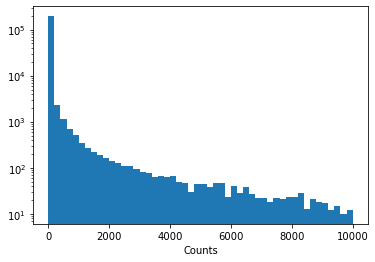

In [22]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [23]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#tokens = <YOUR CODE HERE>---------------------------

tokens = [token for token, number_size in token_counts.items() if number_size >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [24]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [25]:
#token_to_id = <your code here>---------------------
token_to_id = {}
i = 0
for word in tokens:
    token_to_id[word] = i
    i += 1

In [26]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [27]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [28]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [29]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [30]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [31]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [ ]:
generate_batch(data_train, 3, max_len=10)

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE>----------------------------------------------------------

        h = self.conv1(h)
        h = F.relu(h)
        h = self.pool1(h)
        h = self.dense(h)
        
        return h

In [ ]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

In [ ]:
dummy_x.shape

In [ ]:
dummy_v.shape

__Task 2.1__ Create description encoder

In [ ]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
#<YOUR CODE HERE>---------------------------------------------
class JobEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE>
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        
        return  h #<YOUR CODE>

In [ ]:
desc_encoder = JobEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

__ Task 2.2__ Build one network ~~to rule them all~~

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = JobEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        
        self.dense1 = nn.Linear(n_cat_features, 128)
        self.dense2 = nn.Linear(128, 192)
        self.dense3 = nn.Linear(192,32)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dense4 = nn.Linear(32,64)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        #<YOUR CODE>
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)#<YOUR CODE>
        
        # apply categorical encoder
        cat_h = self.dense1(cat_features)
        cat_h = self.dense2(cat_h)
        cat_h = self.dense3(cat_h)
        cat_h = self.dense4(cat_h)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.dense3(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h[:,0]

In [ ]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
opt

In [ ]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [ ]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [ ]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [ ]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [ ]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [112]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


C:\Users\Ariel\AppData\Local\Temp/ipykernel_11032/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	9.04572
	MAE:	26109.33604



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.64423
	MAE:	7302.90501



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.57533
	MAE:	7481.34214



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.42654
	MAE:	6245.75218



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.36856
	MAE:	5556.15623



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.32676
	MAE:	5428.56656



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.31693
	MAE:	5136.30824



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.28391
	MAE:	4900.96694



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.28646
	MAE:	5041.95126



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25123
	MAE:	4596.25230



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.24591
	MAE:	4670.93685



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.23880
	MAE:	4744.83630



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22980
	MAE:	4368.39867



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.21559
	MAE:	4235.40806



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22743
	MAE:	4521.99451



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.20645
	MAE:	4407.68062



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19273
	MAE:	4187.12656



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18772
	MAE:	4030.26978



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19094
	MAE:	4110.06158



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19125
	MAE:	3871.68286



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18441
	MAE:	3911.21228



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18091
	MAE:	3813.73913



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17731
	MAE:	3986.97387



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17674
	MAE:	3735.54279



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16166
	MAE:	3817.15287



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15814
	MAE:	3825.80639



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16101
	MAE:	3739.98930



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15082
	MAE:	3672.77864



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16027
	MAE:	3782.80763



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14992
	MAE:	3713.12587



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15515
	MAE:	3834.43072



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16251
	MAE:	4083.88128



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14300
	MAE:	3604.60203



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14484
	MAE:	3686.59135



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15136
	MAE:	3644.61380



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13639
	MAE:	3391.56499



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14908
	MAE:	3617.33404



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13007
	MAE:	3417.02051



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12878
	MAE:	3407.85119



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12971
	MAE:	3484.04735



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13150
	MAE:	3459.58871



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15233
	MAE:	4009.06718



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14629
	MAE:	3709.33705



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12311
	MAE:	3304.75681



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12770
	MAE:	3373.87607



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16711
	MAE:	4395.64347



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11977
	MAE:	3346.58005



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11827
	MAE:	3287.17018



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11613
	MAE:	3281.07850



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11688
	MAE:	3174.59643



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12095
	MAE:	3363.28098



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13019
	MAE:	3622.81169



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12516
	MAE:	3362.63775



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14528
	MAE:	3490.90962



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11877
	MAE:	3294.20830



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11248
	MAE:	3116.65656



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11445
	MAE:	3225.10751



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11468
	MAE:	3140.53031



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11999
	MAE:	3384.61780



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19762
	MAE:	4070.79988



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12037
	MAE:	3356.77788



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11524
	MAE:	3343.03535



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10815
	MAE:	3064.23083



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10328
	MAE:	3074.39898



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10974
	MAE:	3230.75993



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12595
	MAE:	3645.32919



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10960
	MAE:	3213.44486



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10247
	MAE:	3032.55136



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10521
	MAE:	3147.84435



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09865
	MAE:	2985.02295



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11977
	MAE:	3412.57208



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10001
	MAE:	3027.18010



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10226
	MAE:	3049.60694



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09933
	MAE:	3027.48293



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10156
	MAE:	3015.60207



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09809
	MAE:	3004.23661



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09818
	MAE:	3032.99792



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12417
	MAE:	3614.00788



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10506
	MAE:	3158.55458



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12368
	MAE:	3266.52921



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11029
	MAE:	3259.33380



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10014
	MAE:	2968.30027



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11071
	MAE:	3310.03567



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09685
	MAE:	2999.34953



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10221
	MAE:	3059.80210



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10555
	MAE:	3020.44383



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09254
	MAE:	2962.77767



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09290
	MAE:	2894.62440



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11293
	MAE:	3213.46824



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19729
	MAE:	4105.40306



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11155
	MAE:	3223.19056



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12579
	MAE:	3284.75545



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09944
	MAE:	3002.26931



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09369
	MAE:	2946.23634



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10615
	MAE:	3146.01656



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13975
	MAE:	3451.11644



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10718
	MAE:	3115.89501



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09240
	MAE:	2926.39995



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09463
	MAE:	3006.41874



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11463
	MAE:	3500.29080



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09331
	MAE:	2942.37854



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10144
	MAE:	3200.81816



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08745
	MAE:	2842.98570



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12632
	MAE:	3319.28700



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08944
	MAE:	2929.02484



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08969
	MAE:	2901.22373



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09608
	MAE:	3021.30664



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09901
	MAE:	3123.46706



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09824
	MAE:	3000.27741



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09154
	MAE:	2958.23534



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08776
	MAE:	2907.70377



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08913
	MAE:	2839.45030



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09380
	MAE:	2959.99828



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08923
	MAE:	2868.78353



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10335
	MAE:	3052.65083



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08955
	MAE:	2817.13753



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09038
	MAE:	2863.57692



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09216
	MAE:	2998.91293



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09546
	MAE:	2869.44630



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08906
	MAE:	2897.70974



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09801
	MAE:	3097.17459



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09225
	MAE:	2993.54631



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09224
	MAE:	2845.90334



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08721
	MAE:	2860.25058



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09177
	MAE:	2947.46352



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10881
	MAE:	3358.72943



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10087
	MAE:	3126.29972



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09432
	MAE:	2979.67602



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09727
	MAE:	2956.26665



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08662
	MAE:	2816.85924



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09314
	MAE:	2975.54466



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09622
	MAE:	2910.08405



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08913
	MAE:	2892.91104



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10971
	MAE:	3436.08662



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08016
	MAE:	2739.81134



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09881
	MAE:	2935.76067



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08627
	MAE:	2845.06931



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09284
	MAE:	2859.61360



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09162
	MAE:	2934.24461



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09577
	MAE:	3059.50558



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08229
	MAE:	2786.83707



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08170
	MAE:	2730.51451



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07950
	MAE:	2793.08549



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09333
	MAE:	3052.12498



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08987
	MAE:	2876.90348



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10160
	MAE:	3240.23608



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09618
	MAE:	3009.86628



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08543
	MAE:	2846.49568



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09181
	MAE:	2893.22461



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09224
	MAE:	2992.51632



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08821
	MAE:	2938.37570



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08511
	MAE:	2823.86626



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10073
	MAE:	3108.87169



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08683
	MAE:	2789.95414



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08662
	MAE:	2849.26802



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08337
	MAE:	2797.67871



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09016
	MAE:	2898.88301



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08314
	MAE:	2795.26041



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08230
	MAE:	2693.43482



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14006
	MAE:	4095.83559



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08161
	MAE:	2803.56597



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10231
	MAE:	3221.99193



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08080
	MAE:	2714.65292



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12972
	MAE:	3361.33678



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08646
	MAE:	2835.30657



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08025
	MAE:	2685.83205



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08355
	MAE:	2759.54177



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11587
	MAE:	3562.75411



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08798
	MAE:	2906.89870



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08316
	MAE:	2742.63889



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09669
	MAE:	3079.52351



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09036
	MAE:	3021.22930



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07705
	MAE:	2663.37862



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08430
	MAE:	2846.52401



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07855
	MAE:	2711.35613



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08929
	MAE:	2991.22093



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08904
	MAE:	2863.47193



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08111
	MAE:	2719.39068



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07910
	MAE:	2701.42670



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08081
	MAE:	2707.53179



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07735
	MAE:	2677.01078



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08731
	MAE:	2911.23227



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07736
	MAE:	2728.71899



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07904
	MAE:	2694.74903



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07205
	MAE:	2616.58574



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07869
	MAE:	2688.58688



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08239
	MAE:	2771.62156



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08140
	MAE:	2688.64998



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08472
	MAE:	2777.62882



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07781
	MAE:	2678.70983



Training:


  0%|          | 0/100 [01:03<?, ?it/s]

	Loss:	0.08177
	MAE:	2726.34217



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07849
	MAE:	2665.97614



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08123
	MAE:	2713.52132



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07864
	MAE:	2678.85263



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08150
	MAE:	2753.19604



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11958
	MAE:	3711.50125



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07780
	MAE:	2690.46142



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08015
	MAE:	2699.24517



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07858
	MAE:	2677.64933



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07841
	MAE:	2688.64111





In [113]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


C:\Users\Ariel\AppData\Local\Temp/ipykernel_11032/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07841
	MAE:	2688.64111





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

**Reducing MAE Average Pooling**
**I realized that using Average pooling instead of max pooling had better results.The the MAE was reduced much faster with average pooling. For instance, in the epoch 5 the MAE was 5556.1562. In contrast,the MAE using average pooling in the epoch 5 was 4322.00829.**

**Using Word2Vec**
**Also, using word2vec improved the MAE**

**I am not quite sure why these changes improved the MAE in this DL, nlp assigment. However, I guess it is better to have the average pooling rather than the max pooling in NLP tasks**

In [157]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class MeanPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        
        return x.mean(dim=self.dim)

In [158]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = MeanPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE>----------------------------------------------------------

        h = self.conv1(h)
        h = F.relu(h)
        h = self.pool1(h)
        h = self.dense(h)
        
        return h

In [159]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


In [160]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
#<YOUR CODE HERE>---------------------------------------------
class JobEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = MeanPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE>
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        
        return  h #<YOUR CODE>

In [161]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = JobEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        
        self.dense1 = nn.Linear(n_cat_features, 128)
        self.dense2 = nn.Linear(128, 192)
        self.dense3 = nn.Linear(192,32)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dense4 = nn.Linear(32,64)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        #<YOUR CODE>
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)#<YOUR CODE>
        
        # apply categorical encoder
        cat_h = self.dense1(cat_features)
        cat_h = self.dense2(cat_h)
        cat_h = self.dense3(cat_h)
        cat_h = self.dense4(cat_h)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = self.dense3(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return joint_h[:,0]

In [162]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [163]:
opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [164]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [165]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [166]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

In [167]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [172]:
num_epochs = 10
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [178]:
batch[target_column]

array([10.221977 , 10.915107 ,  9.506065 , 10.308986 ,  9.903538 ,
        9.615872 ,  9.639587 , 10.239996 , 10.558439 , 10.868568 ,
        9.7981825,  8.633553 , 10.389026 ,  9.998843 ,  9.914724 ,
       11.082158 ,  9.82558  , 11.225257 , 10.463132 , 10.657283 ,
       10.657283 , 11.002116 ,  9.7981825,  9.757363 ,  9.64866  ,
        9.670357 , 10.59666  , 10.221977 , 10.165891 ], dtype=float32)

In [180]:
reference

tensor([10.2220, 10.9151,  9.5061, 10.3090,  9.9035,  9.6159,  9.6396, 10.2400,
        10.5584, 10.8686,  9.7982,  8.6336, 10.3890,  9.9988,  9.9147, 11.0822,
         9.8256, 11.2253, 10.4631, 10.6573, 10.6573, 11.0021,  9.7982,  9.7574,
         9.6487,  9.6704, 10.5967, 10.2220, 10.1659])

In [181]:
prediction

tensor([10.0778, 10.3217, 10.1717, 10.3717,  9.4636,  9.9025,  9.8658,  9.8658,
        10.5163, 10.5332, 10.0159,  9.5965, 10.3255, 10.1822, 10.3112, 11.0330,
         9.8992, 10.9770, 10.2952, 11.0319, 10.7324, 11.2579,  9.9672,  9.9517,
         9.6234, 10.3004, 10.5265, 10.6472, 10.8117])

In [173]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


C:\Users\Ariel\AppData\Local\Temp/ipykernel_11032/3166325630.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17631
	MAE:	3985.67980



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16191
	MAE:	3821.12678



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16972
	MAE:	3983.82798



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.21341
	MAE:	4956.56510



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.17739
	MAE:	4030.05785



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19173
	MAE:	3989.95007



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16388
	MAE:	3947.74885



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16343
	MAE:	4139.34023



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15821
	MAE:	3912.52368



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16731
	MAE:	3791.46908



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16798
	MAE:	4000.84029



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19950
	MAE:	4961.66486



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16701
	MAE:	3979.19898



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15088
	MAE:	3667.86738



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15819
	MAE:	4003.92761



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14202
	MAE:	3549.17263



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16180
	MAE:	3945.91211



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12924
	MAE:	3489.38821



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14791
	MAE:	3719.32912



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13446
	MAE:	3630.84895



